In [1]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional,\
                      GRU, Dropout, GlobalAveragePooling1D, Conv1D, TimeDistributed
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
import re
from nltk import sent_tokenize, word_tokenize, pos_tag, ne_chunk
import nltk.data
from nltk.tokenize.punkt import PunktSentenceTokenizer, PunktTrainer
import pickle
import math
#import collections.Iterable as Iterable

import sklearn.metrics as metrics
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
import os, inspect, sys
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
from unwiki import unwiki
import ner
from embed_utils import open_w2v

In [2]:
with open('/media/hd1/wikipedia/wiki_definitions_improved.txt', 'r') as wiki_f:
    wiki = wiki_f.readlines()

# Get data and train the Sentence tokenizer
# Uses a standard algorithm (Kiss-Strunk) for unsupervised sentence boundary detection
text = ''
for i in range(1550):
    text += unwiki.loads(eval(wiki[i].split('-#-%-')[2]))

trainer = PunktTrainer()
trainer.INCLUDE_ALL_COLLOCS = True
trainer.train(text)
sent_tok = PunktSentenceTokenizer(trainer.get_params())
print(sent_tok._params.abbrev_types)

{'ginebra', 'z-1', 'cf', 'fig', 'i.e', 'ph.d', 'gr', 'u.s', 'technician', 'u.n', 'pl', 'p.h.d', 'nationality', 'jie', 'happiness', '4n', 'exhibition', 'j.w', 'hk', 'ἀ', 'c.w', 'q.v', 'j.c', 'r.a', 'vibrations', 'a.k.a', 'mtv', 'n.b', 'e.g', 'spacewalks', 'qom', 'rod', '4π', 'juniper', "'is", 'sow', 's.c', 'al', 's^2', 'ye', 'i.i.d', 'eng', 'j.d', 'bx', 'x+2', 's.t', 'jr', 'etc', 'oct', 'rim', 'a.i', 'fins', 'p.o.a', 'az', 'fn', 'ca', 'rye', 'f.h', 'g.i'}


In [26]:
# Detecting abbreviations from clean text
with open('/media/hd1/clean_text/math05', 'r') as text_f:
    text = text_f.read()[:100000]

# Get data and train the Sentence tokenizer
# Uses a standard algorithm (Kiss-Strunk) for unsupervised sentence boundary detection

trainer = PunktTrainer()
trainer.INCLUDE_ALL_COLLOCS = True
trainer.train(text, finalize=True)
sent_tok = PunktSentenceTokenizer(trainer.get_params())
print(sent_tok._params.abbrev_types)

{'e.g', 'cf', 'i.e', 'l'}


In [6]:
{'eq', 'i.e', 'e.g', 'f.g', 'eqs', 'w.r.t'}

set

### TODO
* protect _inline_math_ from keras tokenizer, right now it is breaking it up
* Search for a minimal stemmer that finds for example zero-sum games in zero-sum game or absolute continuity 

In [60]:
cfg = {}

word_tok = Tokenizer(oov_token='<UNK>')
clean_str = lambda s: unwiki.loads(eval(s)).replace('\n', ' ')
fields = {'texts': [], 'titles': [], }
for w in wiki:
    title, section, defin_parag = w.split('-#-%-')
    defin_parag = clean_str(defin_parag)
    for defin in sent_tok.tokenize(defin_parag):
        fields['titles'].append(title.lower().strip())
        fields['texts'].append(defin)
word_tok.fit_on_texts(fields['titles'] + fields['texts'])

rev_word_index = (1 + len(word_tok.word_index))*['***']
for word,ind in word_tok.word_index.items():
    rev_word_index[ind] = word

In [61]:
fields['texts'][1683]

'Despite this, unions were formed and began to acquire political power, eventually resulting in a body of labour law that not only legalized organizing efforts, but codified the relationship between employers and those employees organized into unions.'

In [62]:
fields['labels'] = []
fields['tokens'] = word_tok.texts_to_sequences(fields['texts'])
empty_sentence_lst = []
for N in range(len(fields['texts'])):
    title_lst = word_tok.texts_to_sequences([fields['titles'][N].strip()])[0]
    tags = ner.bio_tag.bio_tkn_tagger(title_lst, fields['tokens'][N] )
    try:
        fields['labels'].append(list(zip(*tags))[1])
    except IndexError:
        fields['labels'].append(['0'])
        empty_sentence_lst.append(N)
print(f'Found {len(empty_sentence_lst)} empty sentences')

Found 59 empty sentences


In [5]:
K = 31765
Tex = fields['texts'][K]
Tok = fields['tokens'][K]
Lab = fields['labels'][K]
Tit = fields['titles'][K]
print(f'the title of the article is: {Tit}')
for ind, t in enumerate(Tok):
    print('{0:>5} {1:>12} {2:>5}'.format(t, rev_word_index[t], Lab[ind]))

the title of the article is: palestinians in lebanon
10505 palestinians     2
    9           in     3
 7817      lebanon     3
  200      include     1
    1          the     1
 9535  palestinian     1
 7219     refugees     1
  119          who     1
18498         fled     1
    8           to     1
 7817      lebanon     1
  336       during     1
    1          the     1
 6745         1948     1
 6649    palestine     1
  574          war     1
    6          and     1
   57        their     1
 2780  descendants     1
    1          the     1
 9535  palestinian     1
22650     militias     1
   23        which     1
22551      resided     1
    9           in     1
 7817      lebanon     1
    9           in     1
    1          the     1
 2786        1970s     1
    6          and     1
 2997        1980s     1
    6          and     1
 9535  palestinian     1
 9425    nationals     1
  119          who     1
   40         have     1
 1918     recently     1
 3636        moved    

In [246]:
cfg['maxlen'] = max([len(l) for l in fields['tokens']])//12
cfg['padding'] = 'pre'
train_seq = pad_sequences(fields['tokens'], maxlen=cfg['maxlen'], padding=cfg['padding'])
train_lab = pad_sequences(fields['labels'], maxlen=cfg['maxlen'], padding=cfg['padding'])
train_seq2 = []
train_lab2 = []
for ind, t in enumerate(train_lab):
    if 2 in t:
        train_seq2.append(train_seq[ind])
        train_lab2.append(train_lab[ind])
train_seq2 = np.array(train_seq2)
train_lab2 = np.array(train_lab2)

In [141]:
class NerModel(tf.keras.Model):
    def __init__(self, hidden_num, vocab_size, label_size, embedding_size):
        super(NerModel, self).__init__()
        self.hidden_num = hidden_num
        self.vocab_size = vocab_size
        self.label_size = label_size
        
        self.embedding = Embedding(vocab_size, embedding_size)
        self.biLSTM = Bidirectional(LSTM(hidden_num, return_sequences=True))
        self.dropout = tf.keras.layers.Dropout(0.2)
        self.dense = Dense(label_size)
        
        self.transition_params = tf.Variable(tf.random.uniform(shape=(label_size, label_size)))
        
    def call(self, text, labels=None, training=None):
        text_lens = tf.math.reduce_sum(tf.cast(tf.math.not_equal(text, 0), dtype=tf.int32), axis=-1)
        inputs = self.embedding(text)
        inputs = self.biLSTM(inputs)
        inputs = self.dropout(inputs, training)
        logits = self.dense(inputs)
        
        if labels is not None:
            label_sequences = tf.convert_to_tensor(labels, dtype=tf.int32)
            log_likelihood, self.transition_params = \
            tfa.text.crf_log_likelihood(logits, label_sequences, text_lens,
                                        transition_params=self.transition_params)
            return logits, text_lens, log_likelihood
        else:
            return logits, text_lens
        
#model.summary()

In [9]:
# Train NER model
cfg['learning_rate'] = 0.1
model = NerModel(64, len(word_tok.word_index)+1, 4, 100)
optimizer = tf.keras.optimizers.Adam()
def train_one_step(text_batch, labels_batch):
    with tf.GradientTape() as tape:
        logits, text_lens, log_likelihood = model(text_batch, labels_batch, training=True)
        loss = - tf.reduce_mean(log_likelihood)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss, logits, text_lens

def get_acc_one_step(logits, text_lens, labels_batch):
    paths = []
    accuracy = 0
    for logit, text_len, labels in zip(logits, text_lens, labels_batch):
        viterbi_path, _ = tfa.text.viterbi_decode(logit[:text_len], model.transition_params)
        paths.append(viterbi_path)
        correct_prediction = tf.equal(
            tf.convert_to_tensor(tf.keras.preprocessing.sequence.pad_sequences([viterbi_path],
                                                            padding='post'), dtype=tf.int32),
            tf.convert_to_tensor(tf.keras.preprocessing.sequence.pad_sequences([labels[:text_len]],
                                                            padding='post'), dtype=tf.int32)
        )
        accuracy = accuracy + tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        # print(tf.reduce_mean(tf.cast(correct_prediction, tf.float32)))
    accuracy = accuracy / len(paths)
    return accuracy

best_acc = 0
step = 0
epochs = 20
bs = 1000
for epoch in range(epochs):
    for (text_batch, labels_batch) in \
    [[train_seq2[bs*i:bs*(i+1)], train_lab2[bs*i:bs*(i+1)]]\
     for i in range(math.ceil(len(train_seq2)/bs))]:
        step = step + 1
        loss, logits, text_lens = train_one_step(text_batch, labels_batch)
        if step % 20 == 0:
            accuracy = get_acc_one_step(logits, text_lens, labels_batch)
            print('epoch %d, step %d, loss %.4f , accuracy %.4f' % (epoch, step, loss, accuracy))
            if accuracy > best_acc:
                best_acc = accuracy
                #ckpt_manager.save()
                print("model saved")

epoch 1, step 20, loss 5.8109 , accuracy 0.9755
model saved
epoch 3, step 40, loss 1.7540 , accuracy 0.9940
model saved
epoch 4, step 60, loss 1.6287 , accuracy 0.9976
model saved
epoch 6, step 80, loss 0.6859 , accuracy 0.9990
model saved
epoch 7, step 100, loss 1.0274 , accuracy 0.9979
epoch 9, step 120, loss 0.5475 , accuracy 0.9989
epoch 10, step 140, loss 0.6320 , accuracy 0.9987
epoch 12, step 160, loss 0.5858 , accuracy 0.9989
epoch 13, step 180, loss 0.7105 , accuracy 0.9984
epoch 15, step 200, loss 0.5403 , accuracy 0.9988
epoch 16, step 220, loss 0.5145 , accuracy 0.9987
epoch 18, step 240, loss 0.6273 , accuracy 0.9986
epoch 19, step 260, loss 0.0032 , accuracy 1.0000
model saved


In [10]:
model.summary()

Model: "ner_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  4208300   
_________________________________________________________________
bidirectional (Bidirectional multiple                  84480     
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  516       
Total params: 4,293,312
Trainable params: 4,293,312
Non-trainable params: 0
_________________________________________________________________


In [11]:
sample_str = 'A banach space is defined as named entity recognition'
sample_tok = word_tok.texts_to_sequences([sample_str])
sample_pad = pad_sequences(sample_tok, maxlen=cfg['maxlen'], padding=cfg['padding'])
pred = [model.predict(text_batch[i])[1] for i in range(len(text_batch))]

In [282]:
cf = {'input_dim': len(word_tok.word_index)+1,
      'output_dim': 25,
     'input_length': max([len(l) for l in fields['tokens']])//12,
     'n_tags': 4,
     'batch_size': 1000}
    
# Define the categorical labels
train_lab2_cat = np.array([to_categorical(c, num_classes=cf['n_tags']) for c in train_lab2])
embed_matrix = np.zeros((cf['input_dim'], 200))
coverage_cnt = 0
with open_w2v('/media/hd1/embeddings/model14-14_12-08/vectors.bin') as embed_dict:
    for word, ind in word_tok.word_index.items():
        vect = embed_dict.get(word)
        if vect is not None:
            vect = vect/np.linalg.norm(vect)
            embed_matrix[ind] = vect
            coverage_cnt += 1

Vocabulary size: 667122 and dimension of embed: 200


In [302]:
cf = {'input_dim': len(word_tok.word_index)+1,
      'output_dim': 25,
     'input_length': max([len(l) for l in fields['tokens']])//12,
     'n_tags': 4,
     'batch_size': 1000}

In [351]:
# DEFINE MODEL WITH biLSTM AND TRAIN FUNCTION    
def get_bilstm_lstm_model(cfg_dict):
    model = Sequential()
    # Add Embedding layer
   # model.add(Embedding(cfg_dict['input_dim'], 
   #                     output_dim=cfg_dict['output_dim'],
   #                     input_length=cfg_dict['input_length'],
   #                    weights = [embed_matrix],
   #                    trainable = False))
    model.add(Embedding(cfg_dict['input_dim'], 
                        output_dim=cfg_dict['output_dim'],
                        input_length=cfg_dict['input_length']))
    # Add bidirectional LSTM
    model.add(Bidirectional(LSTM(units=cfg_dict['output_dim'],
                                 return_sequences=True,
                                 dropout=0.2, 
                                 recurrent_dropout=0.2), merge_mode = 'concat'))
    # Add LSTM
    model.add(LSTM(units=cfg_dict['output_dim'],
                   return_sequences=True, dropout=0.2, recurrent_dropout=0.2,
                   recurrent_initializer='glorot_uniform'))
    # Add timeDistributed Layer
    model.add(TimeDistributed(Dense(cfg_dict['n_tags'], activation="relu")))
    #Optimiser 
    adam = Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    model.summary()
    
    return model

def train_model(X, y, model, epochs=10):
    out = {'accuracy': [], 'loss': [], 'val_accuracy': [], 'val_loss': []}
    # fit model for one epoch on this sequence
    res = model.fit(X, y, verbose=1, epochs=epochs,
                    batch_size=cf['batch_size'],
                    validation_split=0.2 )
    out['accuracy'].append(res.history['accuracy'])
    out['val_accuracy'].append(res.history['val_accuracy'])
    out['loss'].append(res.history['loss'])
    out['val_loss'].append(res.history['val_loss'])
    return out
model_bilstm_lstm = get_bilstm_lstm_model(cf)
#plot_model(model_bilstm_lstm)

Model: "sequential_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_51 (Embedding)     (None, 42, 25)            1052100   
_________________________________________________________________
bidirectional_50 (Bidirectio (None, 42, 50)            10200     
_________________________________________________________________
lstm_101 (LSTM)              (None, 42, 25)            7600      
_________________________________________________________________
time_distributed_49 (TimeDis (None, 42, 4)             104       
Total params: 1,070,004
Trainable params: 1,070,004
Non-trainable params: 0
_________________________________________________________________


In [352]:
train_lab2_cat = np.array([to_categorical(c, num_classes=cf['n_tags']) for c in train_lab2])
history = train_model(train_seq2, train_lab2_cat, model_bilstm_lstm, epochs=250)

Epoch 1/250
9/9 [==============================] - 2s 231ms/step - loss: 4.7187 - accuracy: 0.4372 - val_loss: 1.1146 - val_accuracy: 0.7263
Epoch 2/250
9/9 [==============================] - 2s 198ms/step - loss: 1.0899 - accuracy: 0.6726 - val_loss: 1.0372 - val_accuracy: 0.6554
Epoch 3/250
9/9 [==============================] - 2s 198ms/step - loss: 0.9811 - accuracy: 0.6547 - val_loss: 0.9227 - val_accuracy: 0.6728
Epoch 4/250
9/9 [==============================] - 2s 195ms/step - loss: 0.8891 - accuracy: 0.6846 - val_loss: 0.8544 - val_accuracy: 0.7126
Epoch 5/250
9/9 [==============================] - 2s 201ms/step - loss: 0.8342 - accuracy: 0.7280 - val_loss: 0.8232 - val_accuracy: 0.7525
Epoch 6/250
9/9 [==============================] - 2s 199ms/step - loss: 0.8009 - accuracy: 0.7639 - val_loss: 0.7965 - val_accuracy: 0.7820
Epoch 7/250
9/9 [==============================] - 2s 196ms/step - loss: 0.7697 - accuracy: 0.7940 - val_loss: 0.7654 - val_accuracy: 0.8039
Epoch 8/250
9

In [191]:
sample_str = 'banach spaces are defined as complete vector space of some king'
sample_tok = word_tok.texts_to_sequences([sample_str])
#sample_pad = pad_sequences(sample_tok, maxlen=cf['input_length'], padding=cfg['padding'])
sample_pad = train_seq2[N]
pred = model_bilstm_lstm.predict(sample_pad)
#np.argmax(pred.squeeze(), axis=1)
pred

array([[[0.04379983, 0.        , 0.        , 0.        ]],

       [[0.04379983, 0.        , 0.        , 0.        ]],

       [[0.04379983, 0.        , 0.        , 0.        ]],

       [[0.04379983, 0.        , 0.        , 0.        ]],

       [[0.04379983, 0.        , 0.        , 0.        ]],

       [[0.04379983, 0.        , 0.        , 0.        ]],

       [[0.04379983, 0.        , 0.        , 0.        ]],

       [[0.04379983, 0.        , 0.        , 0.        ]],

       [[0.04379983, 0.        , 0.        , 0.        ]],

       [[0.04379983, 0.        , 0.        , 0.        ]],

       [[0.04379983, 0.        , 0.        , 0.        ]],

       [[0.04379983, 0.        , 0.        , 0.        ]],

       [[0.04379983, 0.        , 0.        , 0.        ]],

       [[0.04379983, 0.        , 0.        , 0.        ]],

       [[0.04379983, 0.        , 0.        , 0.        ]],

       [[0.04379983, 0.        , 0.        , 0.        ]],

       [[0.04379983, 0.        , 0.     

In [345]:
train_seq2[N]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,   35,
       5756,   65, 8216,  266, 1309,   18,   19, 7531, 2699, 4470,   20,
          2, 1613,    3,    2, 9206,   18,   42,    9, 1005,    4, 8590,
        100,  501,  200,   16,  166,   20, 2258, 1416,   65], dtype=int32)

In [347]:
T = train_seq2[N].reshape(1,42)
model_bilstm_lstm.predict(T)

array([[[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]]], dtype=float32)

In [361]:
def decoder(T, L):
    pred = model_bilstm_lstm.predict(T)
    P = np.argmax(pred.squeeze(), axis=1)
    for ind, t in enumerate(T):
        if True: #t != 0:
            print("{0:>22}: {1:} {2:}".format(rev_word_index[t], L[ind], P[ind]))
#decoder(sample_pad[0], np.argmax(pred.squeeze(), axis=1))
N = -52
decoder(train_seq2[N], train_lab2[N])

                   ***: 0 0
                   ***: 0 0
                   ***: 0 0
                   ***: 0 0
                   ***: 0 0
                   ***: 0 0
                   ***: 0 0
                   ***: 0 0
                   ***: 0 0
                   ***: 0 0
                   ***: 0 0
                   ***: 0 0
                   ***: 0 0
                   ***: 0 0
                   ***: 0 0
                   ***: 0 0
                   ***: 0 0
                   ***: 0 0
                   ***: 0 0
                   ***: 0 0
                   ***: 0 0
                   ***: 0 0
                   ***: 0 0
                   ***: 0 0
                   ***: 0 0
                   ***: 0 0
                   ***: 0 0
                   ***: 0 0
                   ***: 0 0
                   ***: 0 0
                   ***: 0 0
                 there: 1 1
                   are: 1 1
                   two: 1 1
            variations: 1 1
                    

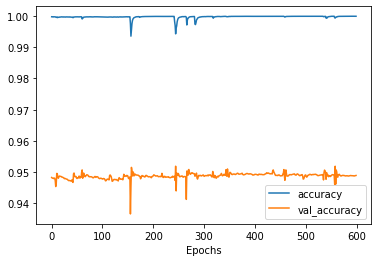

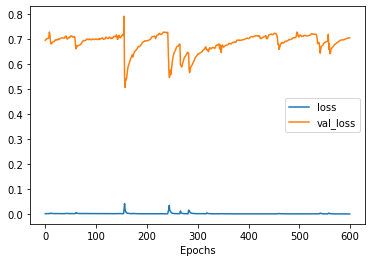

In [278]:
def plot_graphs(history, string, start_at=0):
    plt.plot(history[string][start_at:])
    plt.plot(history['val_'+string][start_at:])
    plt.xlabel('Epochs')
    plt.ylabel(string[start_at:])
    plt.legend([string, 'val_'+string])
    plt.show()
    
plot_graphs(history, "accuracy", start_at=400)
plot_graphs(history, "loss", start_at=400)

In [362]:
wiki[850]

'Indicator function  -#-%-  Definition  -#-%-  "The indicator function of a subset \'\'A\'\' of a set \'\'X\'\' is a function\\n\\n:<math>\\\\mathbf{1}_A \\\\colon X \\\\to \\\\{ 0,1 \\\\} </math>\\n\\ndefined as\\n\\n:<math>\\\\mathbf{1}_A(x) :=\\n\\\\begin{cases}\\n1 &\\\\text{if } x \\\\in A, \\\\\\\\\\n0 &\\\\text{if } x \\\\notin A.\\n\\\\end{cases}\\n</math>\\n\\nThe [[Iverson bracket]] allows the equivalent notation, <math>[x\\\\in A]</math>, to be used instead of <math>\\\\mathbf{1}_A(x)</math>.\\n\\nThe function <math>\\\\mathbf{1}_A</math> is sometimes denoted <math>I_A</math>, <math>\\\\chi_A</math>, \'\'K<sub>A</sub>\'\' or even just <math>A</math>. (The [[Greek alphabet|Greek letter]] <math>\\\\chi</math> appears because it is the initial letter of the Greek word χαρακτήρ, which is the ultimate origin of the word \'\'characteristic\'\'.)\\n\\nThe set of all indicator functions on <math>X</math> can be identified with <math>\\\\mathcal{P}(X)</math>, the [[power set]] of <ma